In [1]:
from io import BytesIO

from pydicom import dcmread, dcmwrite
from pydicom.filebase import DicomFileLike

from pydicom.uid import generate_uid
from datetime import datetime
from configparser import ConfigParser

import pandas as pd
import numpy as np

In [2]:
ds = dcmread('DosePlaneTemplate.dcm')

In [3]:
ds.SOPInstanceUID = generate_uid()
ds.file_meta.MediaStorageSOPClassUID = ds.SOPInstanceUID
ds.StudyInstanceUID = generate_uid()
ds.SeriesInstanceUID = generate_uid()
ds.FrameOfReferenceUID = generate_uid(prefix=None)
#ds.PlanReferencedSOPInstanceUID = generate_uid()
ds.StudyDate = datetime.now().strftime('%Y%m%d')
ds.StudyTime = datetime.now().strftime('%H%M%S.%f')
ds.Manufacturer = 'pychromic'
ds.StationName = ''
ds.StudyDescription='Radiohromic Dosimetry'
ds.SeriesDescription='Dose Plane'
ds.PhysiciansOfRecord = ''
ds.ManufacturerModelName = 'chromLit'

config = ConfigParser()
config.read('../config/filmQAp.config')

ds.PatientName = config['Demographics']['PatientFamilyName'] + '^' + config['Demographics']['PatientName']
ds.PatientID = config['Demographics']['PatientId']
ds.PatientBirthDate = ''
ds.PatientBirthTime = ''
ds.PatientSex = config['Demographics']['gender']
ds.OtherPatientIDs = config['Demographics']['patientid']

In [4]:
def write_dataset_to_bytes(dataset):
    # create a buffer
    with BytesIO() as buffer:
        # create a DicomFileLike object that has some properties of DataSet
        memory_dataset = DicomFileLike(buffer)
        # write the dataset to the DicomFileLike object
        dcmwrite(memory_dataset, dataset)
        # to read from the object, you have to rewind it
        memory_dataset.seek(0)
        # read the contents as bytes
        return memory_dataset.read()

In [5]:
dcmbinaryfile = write_dataset_to_bytes(ds)

In [5]:
ncols = len(pd.read_csv('Film.dxf', header=48, sep='\t', index_col=False, nrows=1).columns)
ddf = pd.read_csv('Film.dxf', header=48, sep='\t', names=np.arange(ncols))

In [6]:
import matplotlib.pyplot as plt 

In [13]:
%cd ..
from pyfilmqa import dcmWriter

/Users/maqui/Documents/devel/chromLit/stFilmQAp


In [16]:
dcmByteString = dcmWriter(Data=ddf.values, imfile='img_dir/Film.tif', config=config)

In [19]:
dose.max()

2576970046200000.0

In [40]:
df.pixel_array * float(df.DoseGridScaling)

array([[   0.        ,    0.        ,    0.        , ..., 1751.269265  ,
        1359.76105167, 1751.271745  ],
       [4362.42727333, 1751.27422833, 3298.53951   , ..., 1750.82503667,
        4016.51462833, 1752.20317167],
       [2723.77036333, 1748.364455  , 3827.67485333, ..., 1751.69710667,
        1422.48151   , 1751.67472167],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 1758.381095  ,
         358.27137667, 1758.39242167],
       [3087.63815   , 1758.39857333, 1150.348005  , ..., 1752.36347333,
        2110.98619   , 1753.97445333],
       [   0.        ,    0.        ,    0.        , ..., 1758.38270833,
         939.36654167, 1758.39402333]])

In [41]:
float(df.DoseGridScaling)

1.6666666666666667e-06

In [49]:
df

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Dose Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.19021917055803645300606151942474966586
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.246.352.70.2.1.7
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.1'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0012) Instance Creation Date              DA: '20220623'
(0008, 0013) Instance Creation Time              TM: '120601.334000'
(0008, 0016) SOP Class UID                       UI: RT Dose Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.1902191705580364530060

In [36]:
440*455*8

1601600

In [45]:
df.pixel_array

array([[         0,          0,          0, ..., 1050761559,  815856631,
        1050763047],
       [2617456364, 1050764537, 1979123706, ..., 1050495022, 2409908777,
        1051321903],
       [1634262218, 1049018673, 2296604912, ..., 1051018264,  853488906,
        1051004833],
       ...,
       [         0,          0,          0, ..., 1055028657,  214962826,
        1055035453],
       [1852582890, 1055039144,  690208803, ..., 1051418084, 1266591714,
        1052384672],
       [         0,          0,          0, ..., 1055029625,  563619925,
        1055036414]], dtype=uint32)

In [8]:
dosef = ddf.values

ds.Rows, ds.Columns = dosef.shape
ds.PixelSpacing = [0.16, 0.16]
ds.DoseComment = 'QA Film'
ds.DoseGridScaling = str(dosef.max()**-1*1e-5)
ds.PixelData = (np.array(dosef*float(ds.DoseGridScaling), np.uint32)).tobytes()

dsBinStr = write_dataset_to_bytes(ds)

/Users/maqui/Documents/devel/slit/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: The value length (21) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


In [18]:
uintim = np.array(dosef/float(ds.DoseGridScaling), np.uint32)

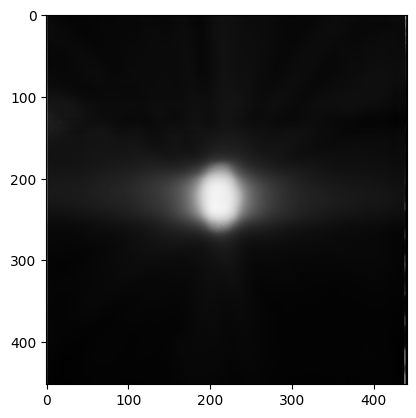

In [19]:
plt.imshow(uintim, cmap=plt.cm.gray)

In [20]:
uintim

array([[3363999,  875799,   92800, ...,  179799, 3363999,  388600],
       [3363999,  869999,   92800, ...,  156600, 2801400,   40600],
       [3363999,  864199,   98600, ...,  156600, 2783999,   40600],
       ...,
       [3363999,  638000,   11600, ..., 3363999,   75400,       0],
       [3363999,  643800,   11600, ..., 3363999,   81200,       0],
       [3363999,  643800,    5800, ..., 3363999,   81200,       0]],
      dtype=uint32)

In [15]:
float(ds.DoseGridScaling)

1.724137931034483e-06

In [19]:
rds = dcmread(BytesIO(dcmByteString))

In [23]:
rds.file_meta.MediaStorageSOPInstanceUID

'1.2.826.0.1.3680043.8.498.12385610985700372221159710995155420731'